In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight # <-- Importar para calcular pesos
#from imblearn.pipeline import Pipeline as ImbPipeline
#from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('/mnt/c/Users/AcerGamer/Downloads/Tuberculose/Projeto-Tuberculose/dados/arquivos_csv/dados_tuberculose_transformados.csv', low_memory=False)

In [3]:
porcentagem_nulos = df.isnull().mean() * 100
colunas_para_remover = porcentagem_nulos[porcentagem_nulos > 30].index
df = df.drop(columns=colunas_para_remover)
print(f"Restaram {df.shape[1]} colunas após remoção de ausentes.")


Restaram 48 colunas após remoção de ausentes.


In [4]:
# --- Seleção de Colunas para o Modelo ---
colunas_modelo = [
    'FORMA',            # variável alvo
    'CS_SEXO',
    'CS_RACA',
    'NU_IDADE_N',
    'HIV',
    'AGRAVAIDS',
    'AGRAVALCOO',
    'RAIOX_TORA',
    'BACILOSC_E',
    'CULTURA_ES',
    'NU_ANO'            # ano da notificação
]
df_modelo = df[colunas_modelo].copy()


# --- Conversão da coluna NU_IDADE_N ---

In [5]:
df_modelo['NU_IDADE_N'] = df_modelo['NU_IDADE_N'].fillna(0)

In [6]:
def converter_idade_para_modelo(nu_idade_n):
    if pd.isna(nu_idade_n) or int(nu_idade_n) == 0: # Trata NaNs ou 0000 como idade ignorada
        return np.nan # Retorna np.nan para ser imputado posteriormente

    nu_idade_n = int(nu_idade_n) # Garante que é inteiro para as operações
    unidade = nu_idade_n // 1000
    valor = nu_idade_n % 1000

    if unidade == 1:  # Horas
        return valor / (24 * 365)
    elif unidade == 2:  # Dias
        return valor / 365
    elif unidade == 3:  # Meses
        return valor / 12
    elif unidade == 4:  # Anos
        return valor
    else: # Idade ignorada ou inválida (ex: '0000')
        return np.nan

In [7]:
# Aplica a função para criar a coluna de idade em anos correta
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_N'].apply(converter_idade_para_modelo)


In [8]:
# Preencher NaNs na nova coluna de idade (se houver, após a conversão) com a mediana
mediana_idade_correta = df_modelo['NU_IDADE_ANOS_CORRETA'].median()
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_ANOS_CORRETA'].fillna(mediana_idade_correta)


In [9]:
# Criar Faixa Etária a partir da idade correta
bins = [0, 18, 35, 50, 65, 120]
labels = ['Jovem', 'Adulto Jovem', 'Adulto', 'Idoso', 'Muito Idoso']
df_modelo['faixa_etaria'] = pd.cut(df_modelo['NU_IDADE_ANOS_CORRETA'], bins=bins, labels=labels, right=False, include_lowest=True)


In [10]:
# 2. Criar um contador de comorbidades/fatores de risco
# Garantir que AGRAVAIDS e AGRAVALCOO sejam numéricos antes de operar
df_modelo['AGRAVAIDS'] = pd.to_numeric(df_modelo['AGRAVAIDS'], errors='coerce').fillna(0.0)
df_modelo['AGRAVALCOO'] = pd.to_numeric(df_modelo['AGRAVALCOO'], errors='coerce').fillna(0.0)

df_modelo['total_comorbidades'] = (df_modelo['AGRAVAIDS'] == 1.0).astype(int) + \
                                  (df_modelo['AGRAVALCOO'] == 1.0).astype(int)


In [11]:
# 3. Criar feature de interação para HIV com AIDS
# Preencher NaNs antes da comparação para 'HIV'
df_modelo['HIV'] = df_modelo['HIV'].fillna('Não Informado')

df_modelo['hiv_positivo_com_aids'] = ((df_modelo['HIV'] == 'Reagente') & (df_modelo['AGRAVAIDS'] == 1.0))

# Remover colunas originais que foram transformadas/substituídas
df_modelo = df_modelo.drop(columns=['NU_IDADE_N', 'AGRAVAIDS', 'AGRAVALCOO'])


# --- Preparação dos Dados para o Modelo ---

In [12]:
# Preencher NaNs da FORMA com a moda antes de converter para int (se houver)
df_modelo['FORMA'] = df_modelo['FORMA'].fillna(df_modelo['FORMA'].mode()[0])
y = df_modelo['FORMA'].astype(int)
X = df_modelo.drop('FORMA', axis=1)


In [13]:
# ---- Codificar a variável alvo 'FORMA' para 0, 1, 2 ----
le = LabelEncoder()
y = le.fit_transform(df_modelo['FORMA'].astype(int)) # y agora será 0, 1, 2
X = df_modelo.drop('FORMA', axis=1)

In [14]:
# Identificar colunas numéricas e categóricas (APÓS a engenharia de features)
#numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
#categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
# Re-identificar colunas numéricas e categóricas após a engenharia de features
# Mantenha NU_IDADE_ANOS_CORRETA, NU_ANO, total_comorbidades como numéricas
numeric_features = ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']

# Adicione as colunas que você identificou como categóricas/ordinais
categorical_features = [
    'CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids',
    'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES' # <<-- Mudei estas para categóricas
]

# Certifique-se de que não há sobreposição ou colunas faltando
# (pode ser útil um print(X.columns) para verificar todas as colunas em X)
print("Colunas numéricas selecionadas:", numeric_features)
print("Colunas categóricas selecionadas:", categorical_features)

Colunas numéricas selecionadas: ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']
Colunas categóricas selecionadas: ['CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids', 'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES']


In [15]:
# --- Construção do Pipeline Avançado (com XGBoost e Imputação Melhorada) ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputa NaNs resultantes da conversão de idade
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputa NaNs nas categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter colunas não especificadas (se houver)
)

## --- Definição da Estratégia de Superamostragem para SMOTE ---

In [37]:
# Criar o pipeline final usando o ImbPipeline
pipeline_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # SelectFromModel: mantido para possível redução de dimensionalidade, mas com um estimador XGBoost
    ('selector', SelectFromModel(XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))),
    ('smote', SMOTE(random_state=42)), 
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'))
])

# --- Treinamento e Avaliação ---

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Iniciando o treinamento do pipeline completo com XGBoost...")
pipeline_final.fit(X_train, y_train)
print("Treinamento concluído.")


Iniciando o treinamento do pipeline completo com XGBoost...


/home/mrdalcol/jupyter_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:27:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mrdalcol/jupyter_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:28:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinamento concluído.


In [32]:
# Fazer predições no conjunto de teste
y_pred = pipeline_final.predict(X_test)


In [33]:
# 1. Reverter as predições e o y_test para os rótulos numéricos originais (1, 2, 3)
# O `le` é o LabelEncoder que você usou para transformar 'FORMA' para 0, 1, 2
y_pred_original_ids = le.inverse_transform(y_pred)
y_test_original_ids = le.inverse_transform(y_test)

In [34]:
mapeamento_nomes_descritivos = {
    1: "Pulmonar",
    2: "Extrapulmonar",
    3: "Mista"
}

class_names_order = ["Pulmonar", "Extrapulmonar", "Mista"]

# Aplicar o mapeamento para as predições e o y_test em formato de nomes
y_pred_nomes = [mapeamento_nomes_descritivos[idx] for idx in y_pred_original_ids]
y_test_nomes = [mapeamento_nomes_descritivos[idx] for idx in y_test_original_ids]

In [35]:
# Relatório de Classificação com Nomes Descritivos
# Ao invés de usar os números, o target_names exibe os nomes no relatório
print("\nRelatório de Classificação com Nomes Descritivos:")
print(classification_report(y_test_nomes, y_pred_nomes, target_names=class_names_order))

cm_nomes = confusion_matrix(y_test_nomes, y_pred_nomes, labels=class_names_order) # <--- AQUI A CORREÇÃO FINAL

print("\nMatriz de Confusão com Nomes Descritivos:")
print(cm_nomes)



Relatório de Classificação com Nomes Descritivos:
               precision    recall  f1-score   support

     Pulmonar       0.66      0.23      0.34     17030
Extrapulmonar       0.06      0.66      0.11      4887
        Mista       0.93      0.65      0.77    128765

     accuracy                           0.60    150682
    macro avg       0.55      0.51      0.40    150682
 weighted avg       0.87      0.60      0.70    150682


Matriz de Confusão com Nomes Descritivos:
[[83471  1897 43397]
 [ 4302  3871  8857]
 [ 1554   107  3226]]


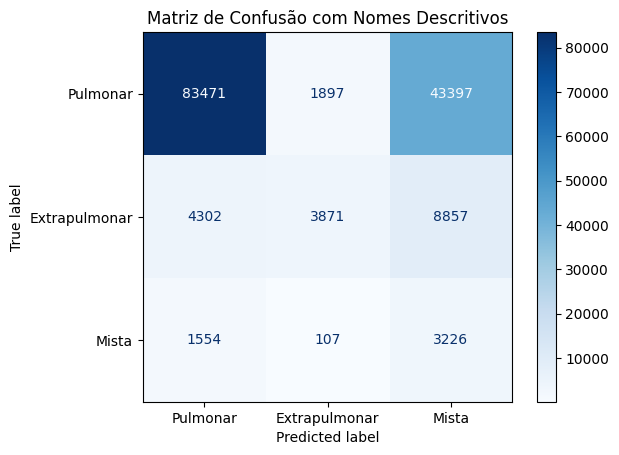

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nomes, display_labels=list(mapeamento_nomes_descritivos.values()))
disp.plot(cmap=plt.cm.Blues) # Pode escolher outro colormap
plt.title('Matriz de Confusão com Nomes Descritivos')
plt.show()

In [ ]:
# Exemplo de Predições (opcional, para visualização rápida)
print("\nExemplo de Predições com Nomes:")
for i in range(10): # Mostra os primeiros 10 exemplos do teste
    print(f"Amostra {i+1}: Real: {y_test_nomes[i]}, Predito: {y_pred_nomes[i]}")


In [4]:
# Carregue seu DataFrame original novamente (ou use o 'df' que já está carregado)
df_original = pd.read_csv('/mnt/c/Users/AcerGamer/Downloads/Tuberculose/Projeto-Tuberculose/dados/arquivos_csv/dados_tuberculose_completos.csv', encoding='latin1')

print("Colunas do DataFrame original e seus tipos de dados:")
print(df_original.info())

print("\nPrimeiras 5 linhas do DataFrame original (para ver os valores):")
print(df_original.head())

/tmp/ipykernel_449/4274405773.py:2: DtypeWarning: Columns (29,30,34,36,37,43,47,49,53,54,56,57,58,59,60,61,63,64,69,87,91,92,93,95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('/mnt/c/Users/AcerGamer/Downloads/Tuberculose/Projeto-Tuberculose/dados/arquivos_csv/dados_tuberculose_completos.csv', encoding='latin1')


Colunas do DataFrame original e seus tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502271 entries, 0 to 502270
Data columns (total 97 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   TP_NOT      502271 non-null  int64  
 1   ID_AGRAVO   502271 non-null  object 
 2   DT_NOTIFIC  502271 non-null  int64  
 3   NU_ANO      502271 non-null  int64  
 4   SG_UF_NOT   502271 non-null  int64  
 5   ID_MUNICIP  502271 non-null  int64  
 6   ID_REGIONA  297899 non-null  float64
 7   DT_DIAG     502271 non-null  int64  
 8   ANO_NASC    500066 non-null  float64
 9   NU_IDADE_N  502068 non-null  float64
 10  CS_SEXO     502271 non-null  object 
 11  CS_GESTANT  502222 non-null  float64
 12  CS_RACA     492687 non-null  float64
 13  CS_ESCOL_N  463257 non-null  float64
 14  SG_UF       502271 non-null  int64  
 15  ID_MN_RESI  502271 non-null  int64  
 16  ID_RG_RESI  296327 non-null  float64
 17  ID_PAIS     389768 non-null  floa